In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import er
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp
from scipy import stats
from sklearn import metrics

data_folder = '/app/data'

# Emergency Room Management Problems

## Emergency Room @ Maggiore Hospital

**We will now consider a couple of Emergency Room management problems**

We will use a dataset for the "Maggiore" hospital in Bologna

<center><img src="assets/maggiore.jpg" width="800px"/></center>

We will consider two main use cases:

* Predicting future arrivals (a Machine Learning problem)
* Managing the ER center resources (a Combinatorial Optimization problem)

## A Look at the Dataset

**We will start as usual by having a look at the dataset**

In [15]:
data = er.load_data(data_folder)
data

,year,ID,Triage,TkCharge,Code,Outcome,Flow
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted,"[triage,visit,RX,visit]"
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted,"[triage,visit,lab,visit]"
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted,"[triage,visit,otolaryngological visit,visit]"
51238,2018,51239,2018-01-01 00:49:51,NaT,white,abandoned,[]
51240,2018,51241,2018-01-01 01:00:40,NaT,green,abandoned,[]
...,...,...,...,...,...,...,...
95665,2019,95666,2019-10-31 23:26:54,2019-10-31 23:41:13,yellow,admitted,"[triage,visit,RX,visit]"
95666,2019,95667,2019-10-31 23:46:43,2019-11-01 09:30:25,green,admitted,"[triage,visit]"
108622,2019,108623,2019-10-31 23:54:05,NaT,green,abandoned,[]
95667,2019,95668,2019-10-31 23:55:32,2019-11-01 00:18:46,yellow,admitted,"[triage,visit]"


## A Look at the Dataset

In [16]:
data.iloc[:3]

,year,ID,Triage,TkCharge,Code,Outcome,Flow
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted,"[triage,visit,RX,visit]"
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted,"[triage,visit,lab,visit]"
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted,"[triage,visit,otolaryngological visit,visit]"


* Each row refers to a single patient
* `Triage` is the arrival time of each patient
* `TKCharge` is the time when a patient starts the first visit
* `Code` refers to the estimated priority (white < green < yellow < red)
* `Outcome` discriminates some special conditios (people quitting, fast tracks)
* `Flow` is the sequence of treatments that actually took place

## A Look at the Dataset

**Let's also have a look at the data types**

In [17]:
data.dtypes

year                 int64
ID                   int64
Triage      datetime64[ns]
TkCharge    datetime64[ns]
Code              category
Outcome           category
Flow                object
dtype: object

* `Flow` is actually a string

**We will initially focus for now on _predicting arrivals_**

...Hence, it makes sense to sort rows by increasing triage time:

In [18]:
data.sort_values(by='Triage', inplace=True)

## Inter-Arrival Times

**Let's check empirically the distribution of the inter-arrival times**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
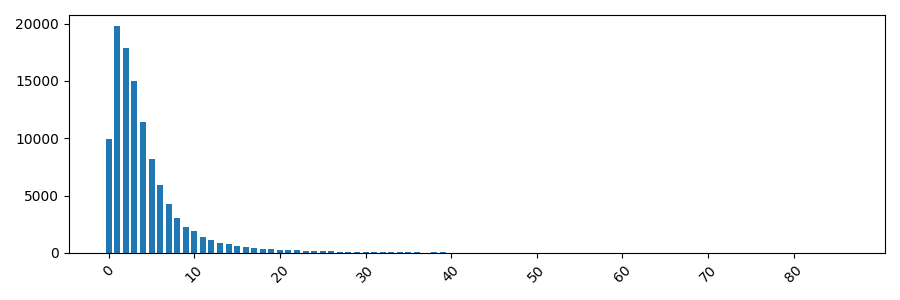

In [31]:
f = '2min'
delta = data['Triage'].iloc[1:].round(f) - data['Triage'].iloc[:-1].round(f).values
tmp = delta.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
er.plot_bars(tmp, tick_gap=10, figsize=figsize)

* There is a number of very low inter-arrival times
* It may be due to how triage is performed (bursts, rather than a steady flow)

## Waiting Time

**Here is the distribution of the waiting times**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
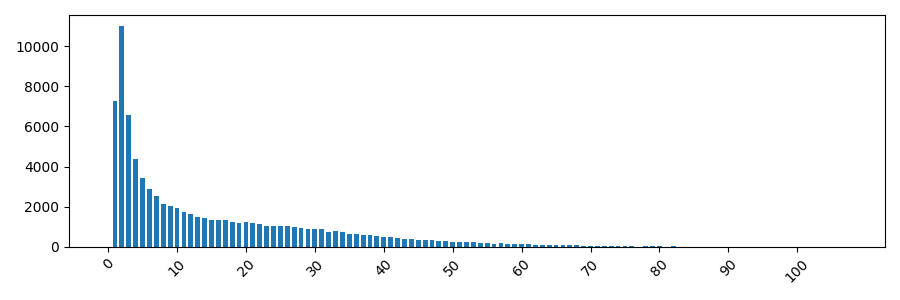

In [35]:
tmp = data[~data['TkCharge'].isnull()]
wait_time = tmp['TkCharge'].round('10min') - tmp['Triage'].round('10min')
tmp = wait_time.value_counts().sort_index().values
tmp = pd.Series(index=np.arange(len(tmp)), data=tmp)
er.plot_bars(tmp, tick_gap=10, figsize=figsize)

* The distritbution is _heavy-tailed_
* I.e. the probability of very long waiting times is non-negligible

## Code Distribution

**The distribution of the priority codes**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
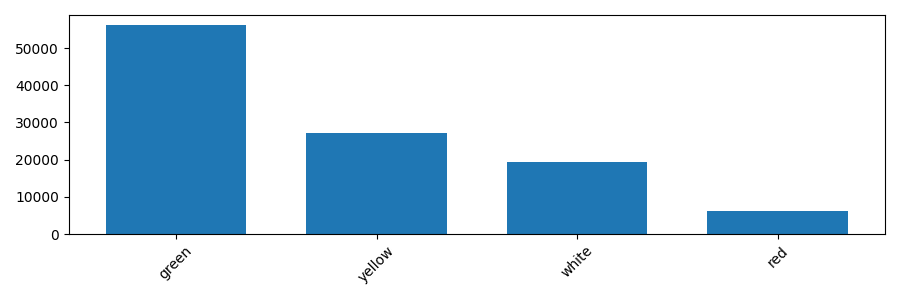

In [36]:
er.plot_bars(data['Code'].value_counts(), figsize=figsize)

* Green code (low severity) form the majority of arrivals
* Yello and red codes (mid and high severity) are in smaller numbers
* White codes (lowest priority) are also not very frequent

## Outcome Distribution

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
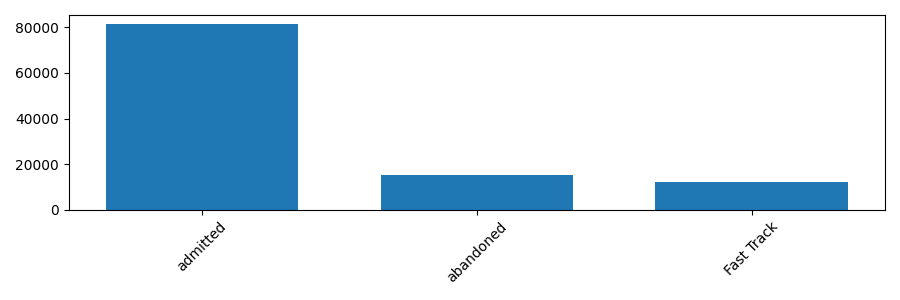

In [37]:
er.plot_bars(data['Outcome'].value_counts(), figsize=figsize)

* Abandons are infrequent, as are "fast track" patients

## Arrival Distribution over Months

**Let's look at the arrival distribution over months**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
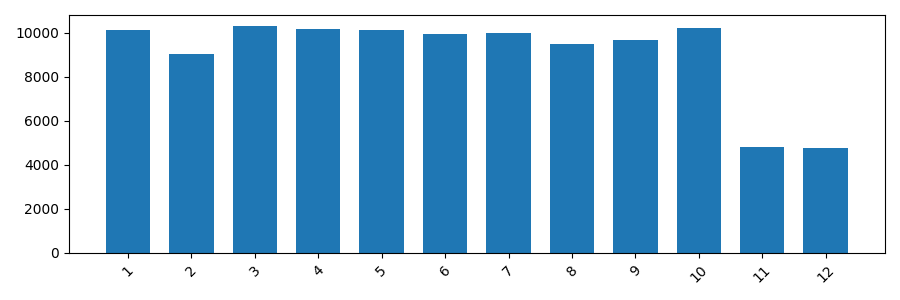

In [38]:
months = data['Triage'].dt.month
er.plot_bars(months.value_counts().sort_index(), figsize=figsize)

* The low values for Nov. and Dec. are due to the 2019 series ending in October
* The distribution seems stable (but we are not plotting standard deviations!)

## Arrival Distribution over Weekdays

**Let's look at the distribution over weekdays**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
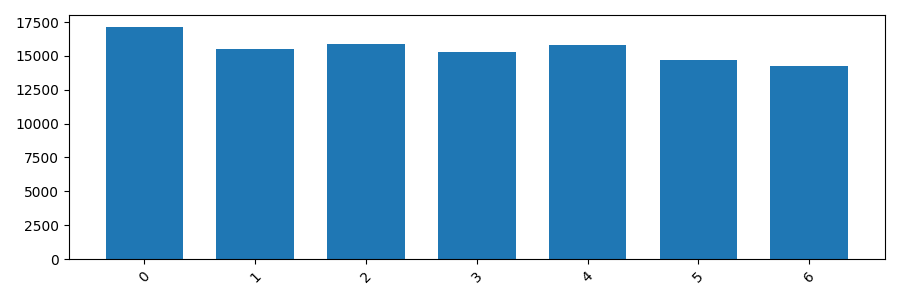

In [39]:
weekdays = data['Triage'].dt.weekday
er.plot_bars(weekdays.value_counts().sort_index(), figsize=figsize)

* Similarly to months, weekdays are likelly to have little predictive power
* ...But it's better not to rush conclusions (we still are not plotting the stddev!)

## Arrival Distribution over Hours

**Let's see now the arrival distribution over the hours of the day**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
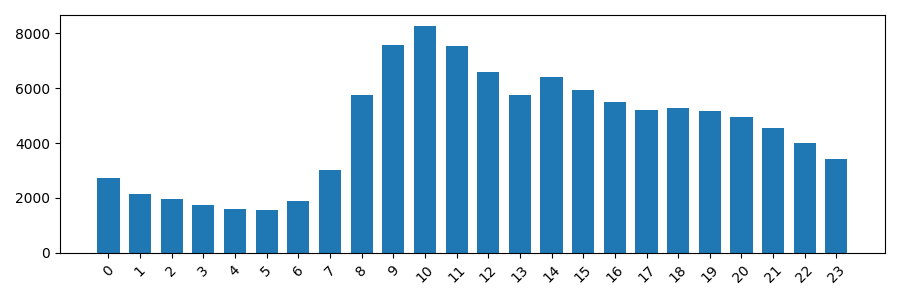

In [40]:
hours = data['Triage'].dt.hour
er.plot_bars(hours.value_counts().sort_index(), figsize=figsize)

* There is _a clear pattern_: the hour of the day will have strong predictive power
* Again, analyzing the standard deviation may provide better insights

# Data Preparation

## Binning

**In our two considered problems:**

* We are not going to revise our decisions continuosly
* We are not interested in predicting the next arrival

Rather:

* We will take decisions _at fixed intervals_
* We care about the expected arrivals _in a given horizon_

**Overall, we need to choose _a meaningful time unit_**

In other words, we need to perform some kind of binning

* We used binning to downsample high-frequency data
* ...We will use binning to _aggregate events with a variable frequency_

## Code-Based Counts

**We will prepare the data to track counts for all priority codes**

In [42]:
codes = pd.get_dummies(data['Code'])
codes.set_index(data['Triage'], inplace=True)
codes.columns = codes.columns.to_list()
print(f'Number of examples: {len(codes)}')
codes.head()

Number of examples: 108625


,green,red,white,yellow
Triage,,,,
2018-01-01 00:17:33,1,0,0,0
2018-01-01 00:20:33,1,0,0,0
2018-01-01 00:47:59,0,0,1,0
2018-01-01 00:49:51,0,0,1,0
2018-01-01 01:00:40,1,0,0,0


* The `get_dummies` function applies a one-hot encoding to categorical value
* The method generates a categorial column index (then converted to list)

## Resampling

**Then, we need to aggregate data with a specified frequency**

In [44]:
codes_b = codes.resample('H').sum()
print(f'Number of examples: {len(codes_b)}')
codes_b.head()

Number of examples: 16056


,green,red,white,yellow
Triage,,,,
2018-01-01 00:00:00,2,0,2,0
2018-01-01 01:00:00,7,1,1,1
2018-01-01 02:00:00,4,1,4,3
2018-01-01 03:00:00,7,0,1,1
2018-01-01 04:00:00,3,0,2,0


* We used the `resample` iterator
* `resample` generater a dataframe with a _dense_ index
* We chose 1 hours are our time unit

## Computing Totals

**We also compute the total number of arrivals for each interval**

In [47]:
cols = ['white', 'green', 'yellow', 'red']
codes_b['total'] = codes_b[cols].sum(axis=1)
codes_b.head()

,green,red,white,yellow,total
Triage,,,,,
2018-01-01 00:00:00,2,0,2,0,4
2018-01-01 01:00:00,7,1,1,1,10
2018-01-01 02:00:00,4,1,4,3,12
2018-01-01 03:00:00,7,0,1,1,9
2018-01-01 04:00:00,3,0,2,0,5


* We use a fixed column list to obtain the same result for multiple executions
* The total count will be less noisy, if the individual terms are independent

## Counts over Time

**Our resampled series can be plotted easily over time**

Let's see the total counts as an example:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
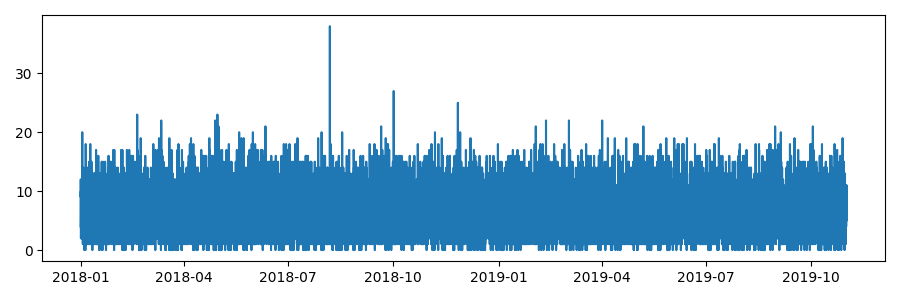

In [48]:
er.plot_series(codes_b['total'], figsize=figsize)

## Counts over Time

**Our resampled series can be plotted easily over time**

The same plot, for the red codes (the counts are significanly lower):

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
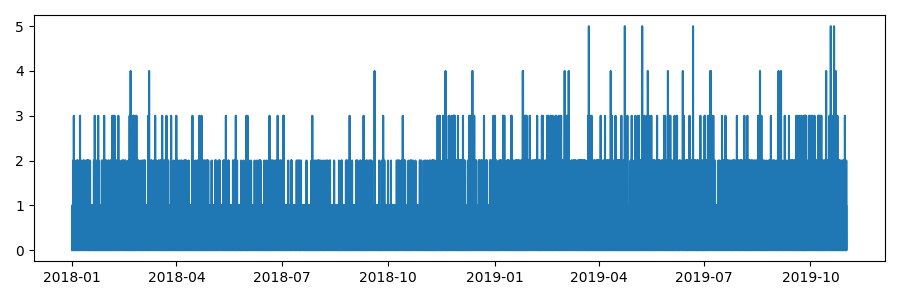

In [51]:
er.plot_series(codes_b['red'], figsize=figsize)

**We are now ready to tackle the first of our ER management problems**

## Variability

**With our binned series, we can compute standard deviations**

Let's check it over different months:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
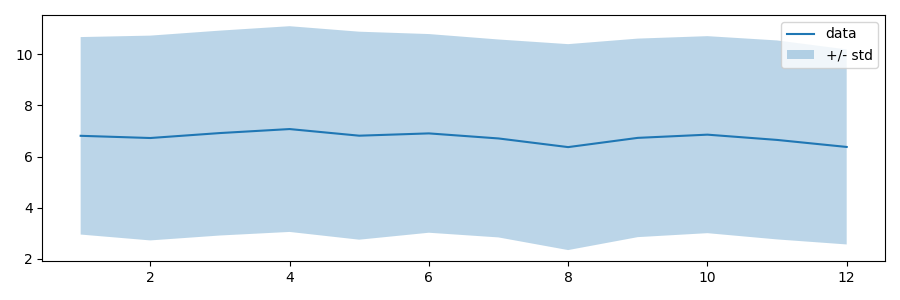

In [52]:
means = codes_b.groupby(codes_b.index.month).mean()
stds = codes_b.groupby(codes_b.index.month).std()
er.plot_series(means['total'], std=stds['total'], figsize=figsize)

* The variability does not change much over different months

## Variability

**Here is the standard deviation over weekdays**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
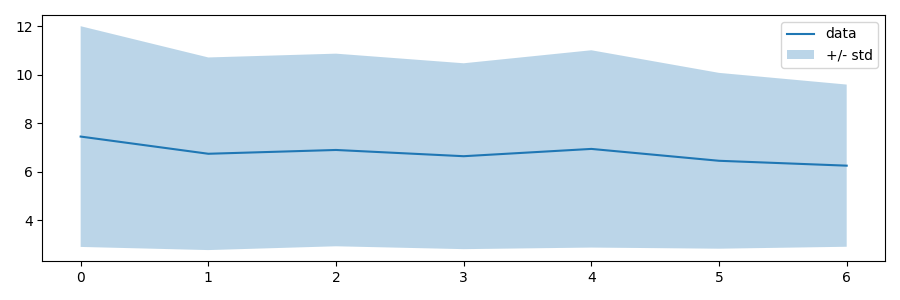

In [53]:
means = codes_b.groupby(codes_b.index.weekday).mean()
stds = codes_b.groupby(codes_b.index.weekday).std()
er.plot_series(means['total'], std=stds['total'], figsize=figsize)

* A decreasing trend, but rather weak

## Variability

**...And finally over hours**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
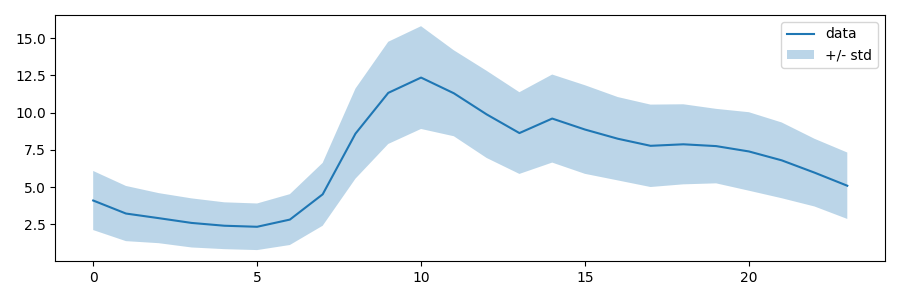

In [54]:
means = codes_b.groupby(codes_b.index.hour).mean()
stds = codes_b.groupby(codes_b.index.hour).std()
er.plot_series(means['total'], std=stds['total'], figsize=figsize)

* Again, unlike the mean, the stdev is similar over the hours of a day